### Dropbox link for beans20190718-trim.nwb (2 GB): https://drive.google.com/file/d/1-0xdEn8oVT6lexBc8mlv7ls84oUvxU4u/view?usp=sharing

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
# data_dir = '/Users/loren/data/nwb_builder_test_data'  # CHANGE ME
data_dir = '/home/jhbak/Data/datajoint_test'
os.environ['NWB_DATAJOINT_BASE_DIR'] = data_dir
os.environ['KACHERY_STORAGE_DIR'] = os.path.join(data_dir, 'kachery-storage')

In [3]:
import nwb_datajoint as nd
import datajoint as dj

import warnings
warnings.simplefilter('ignore')

Please enter DataJoint username: root
Please enter DataJoint password: ········
Connecting root@localhost:3306


In [4]:
nd.insert_sessions(['beans20190718-trim.nwb'])

Populate Session...
Institution...
Lab...
LabMember...
Subject...
DataAcquisitionDevice...
CameraDevice...
Inserted ['beans sleep camera', 'beans run camera']
Probe...
Skipping Apparatus for now...
IntervalList...
Populate NwbfileKachery...
Computing SHA-1 and storing in kachery...
Computing sha1 of /home/jhbak/Data/datajoint_test/beans20190718-trim.nwb
Populate ExperimenterList...
Populate ElectrodeGroup...
Populate Electrode...
Populate Raw...
Estimating sampling rate...
Estimated sampling rate: 20000.0
Importing raw data: Estimated sampling rate:	20000.0 Hz
                    Number of valid intervals:	1
Populate SampleCount...
Populate DIOEvants...
Populate SensorData
Populate TaskEpochs
Populate StateScriptFile
Populate VideoFile
key = {'nwb_file_name': 'beans20190718-trim.nwb', 'epoch': 1}
01_s1
key = {'nwb_file_name': 'beans20190718-trim.nwb', 'epoch': 3}
03_s2
key = {'nwb_file_name': 'beans20190718-trim.nwb', 'epoch': 2}
02_r1
key = {'nwb_file_name': 'beans20190718-trim.nwb', 

#### Let's look at the core schema (note that schema = database_table). 
First, Nwbfile:

In [5]:
nd.common.Nwbfile()

nwb_file_name the name of the NWB file,nwb_file_abs_path the full path name to the file
beans20190718-trim.nwb,/home/jhbak/Data/datajoint_test/beans20190718-trim.nwb


Each NWB file defines a session which also contains information about the subject, institution, etc.:

In [6]:
nd.common.Session()

nwb_file_name the name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
beans20190718-trim.nwb,Beans,"University of California, San Francisco",Loren Frank,beans_01,Reinforcement leaarning,2019-07-18 15:29:47,1970-01-01 00:00:00,Reinforcement learning


We can use the datajoint `Diagram` method to represent the relationship between Nwbfile and Session: 
A Session is identified by a Nwbfile (the primary key; indicated above with the black header text 'nwb_file_name')

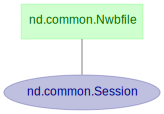

In [7]:
dj.Diagram(nd.common.Nwbfile()) + dj.Diagram(nd.common.Session())

The solid line indicates that the Nwbfile is the primary key for Session, so each Session has exactly one Nwbfile associated with it.

The session also contains references to other schema, including Subject, Institution, etc. 

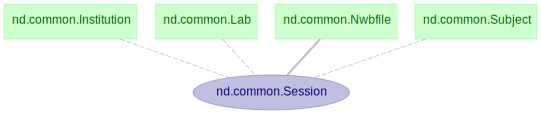

In [8]:
dj.Diagram(nd.common.Nwbfile()) + dj.Diagram(nd.common.Session()) + dj.Diagram(nd.common.Subject()) + dj.Diagram(nd.common.Institution()) + dj.Diagram(nd.common.Lab())

Now let's look at the raw data schema, which contains a reference to the continuous electrophysiology data at the full 20 KHz sampling rate:

In [9]:
nd.common.Raw()

nwb_file_name the name of the NWB file,interval_list_name descriptive name of this interval list,raw_object_id the NWB object ID for loading this object from the file,"sampling_rate Sampling rate calculated from data, in Hz",comments,description
beans20190718-trim.nwb,raw data valid times,b03547f7-7f3c-4d5b-ad9a-0beb267c8992,20000.0,no comments,Electrical series registered on electrode


The raw data has two primary keys: the Session and an IntervalList that defines the set of time intervals for which the data are valid:

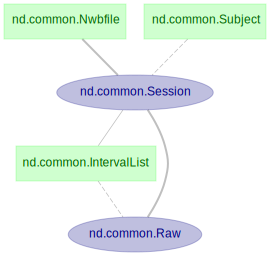

In [10]:
dj.Diagram(nd.common.Subject()) + dj.Diagram(nd.common.Session()) + dj.Diagram(nd.common.Nwbfile()) + dj.Diagram(nd.common.Raw())

The raw data also has a reference to an NWB object id, which allows direct loading of an NWB object from the file. We can get this raw data object with a simple DataJoint query:

In [11]:
raw_data = (nd.common.Raw() & {'nwb_file_name' : 'beans20190718-trim.nwb'}).fetch_nwb()[0]
raw_data

[{'nwb_file_name': 'beans20190718-trim.nwb', 'interval_list_name': 'raw data valid times', 'raw_object_id': 'b03547f7-7f3c-4d5b-ad9a-0beb267c8992', 'sampling_rate': 20000.0, 'comments': 'no comments', 'description': 'Electrical series registered on electrode', 'nwb2load_filepath': '/home/jhbak/Data/datajoint_test/beans20190718-trim.nwb'}]


{'nwb_file_name': 'beans20190718-trim.nwb',
 'interval_list_name': 'raw data valid times',
 'raw_object_id': 'b03547f7-7f3c-4d5b-ad9a-0beb267c8992',
 'sampling_rate': 20000.0,
 'comments': 'no comments',
 'description': 'Electrical series registered on electrode',
 'raw': e-series pynwb.ecephys.ElectricalSeries at 0x140539746775536
 Fields:
   comments: no comments
   conversion: 1.0
   data: <HDF5 dataset "data": shape (4000000, 256), type "<i2">
   description: Electrical series registered on electrode
   electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
   interval: 1
   resolution: -1.0
   timestamps: <HDF5 dataset "timestamps": shape (4000000,), type "<f8">
   timestamps_unit: seconds
   unit: volts}

Thus, `raw_data['raw']` is the electrical series from the NWB file from which data can be retrieved and analyzed.

A couple of notes here:

1) `nd.common.Raw() & {'nwb_file_name' : 'beans20190718-trim.nwb'}` matches elements of the schema with a dictionary with 'nwb_file_name' as the key and, in this case, 'beans20190718-trim.nwb' as the value.

2) `fetch_nwb()` is a special function that was added to the Raw schema to return NWB objects. 


### The first analysis one might do on raw data is to extract the local field potential from a set of electrodes, and there are LFP-related schema for that:

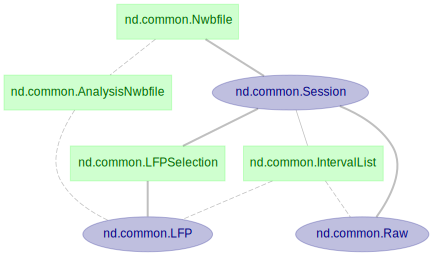

In [12]:
dj.Diagram(nd.common.Session()) + dj.Diagram(nd.common.Nwbfile()) + dj.Diagram(nd.common.Raw()) + dj.Diagram(nd.common.LFP())

Note here that the LFP schema has an entry from the AnalysisNwbfile schema. The AnalysisNwbfile is created when the LFP is created and serves to store the LFP time series. It also contains the key metadata from the parent Nwbfile, so it's easy to know which subject, etc. it came from.

Finally, here's a full diagram of all the schema:

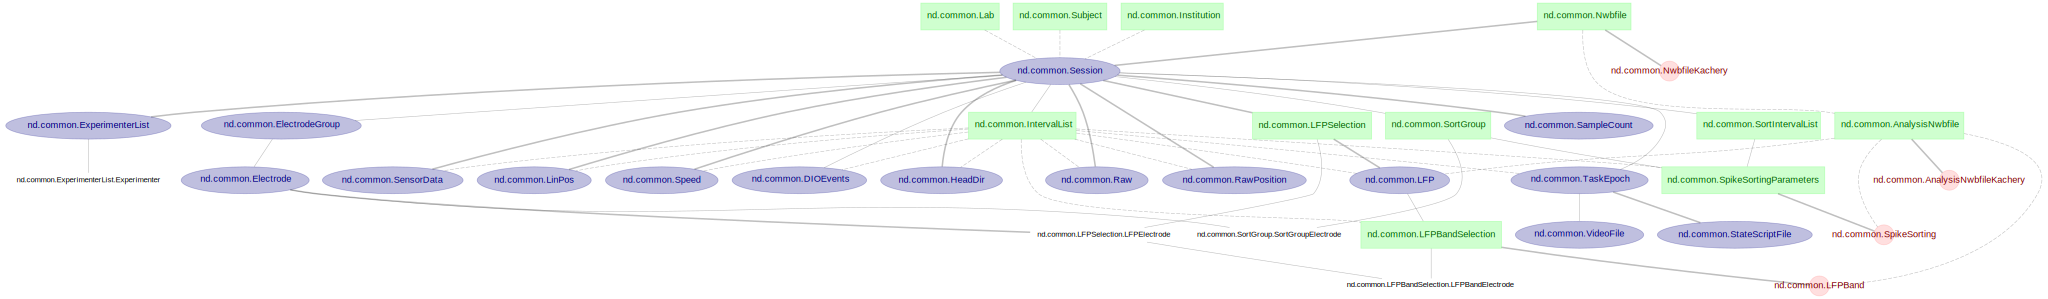

In [13]:
dj.Diagram(nd.common.Session())-2+5

The "kachery" entries refer to a file sharing system developed by Jermey Magland and colleagues, but you do not need to use that to use this repo.